In [1]:
using RCall, LightGraphs, DataFrames, Plots, Measures, CSV, XLSX, Gadfly

In [2]:
R"require(cvxbiclustr)"
R"data(lung)"
R"cellnames = colnames(lung)"
R"lung = as.matrix(lung)"
lung = (@rget lung);
@rget cellnames
n1,n2 = size(lung);
X = lung - repmat(mean(lung,1),n1,1);
X = X./vecnorm(X) * 10;

Loading required package: Matrix
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [3]:
R"library(gdata);
index   = rownames(lung);
orig    = read.xls('/Users/yosikim/Downloads/DatasetA_12600gene.xls');
";
R"A = read.xls('/Users/yosikim/Downloads/SampleData.xls');"; @rget A;
R"probe_orig = orig$probe; probe = rownames(lung);"; @rget probe; @rget probe_orig;
geneindex = findin(probe_orig, probe); @rget orig;
carcinoid = [192;193;194;195;186;196;197;198;187;188;199;189;190;200;201;202;203;204;191;205];
normal    = 142:158;
smallcell = [159;161;162;160;163;164];
ind       = [carcinoid;normal;smallcell];


gdata: Unable to load perl libaries needed by read.xls()
gdata: to support 'XLSX' (Excel 2007+) files.

gdata: Run the function 'installXLSXsupport()'
gdata: to automatically download and install the perl
gdata: libaries needed to support Excel XLS and XLSX formats.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith



In [4]:
A[:Simple_Annotation][[find(A[:sample_type] .== "COID"); find(A[:sample_type] .== "ref.RNA");
    find(A[:sample_type] .== "NL");find(A[:sample_type] .== "SCLC")]];

In [3]:
# a function for BGSM_cartesian_biclust (Section 5.2.)

# y       : a matrix of data
# init    : initialization of y

function BGSM_cartesian_biclust(y;
                                ind1 = 1:size(y,1),
                                ind2 = 1:size(y,2),
                                init = y,
                                v0 = 1e-1,
                                convtol = 1e-14,  
                                iter = 100,
                                verbose = true)
                            
    
    # get size
    n1,n2 = size(y); n = n1 * n2;
    
    
    # initialize
    theta = copy(y);
    k1 = length(ind1); k2 = length(ind2);
    mu1 = copy(y[ind1,:]); mu2 = copy(y[:,ind2]);
    q1 = zeros(n1,k1); q2 = zeros(n2,k2);
    sigmasq1 = 1; sigmasq2 = 1;
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1
        d1 = reshape(sum((repmat(theta,k1,1) - kron(mu1,ones(n1))).^2,2),n1,k1);
        q1 = exp.(-d1/(2*n2*v0)); q1 = q1 ./ sum(q1,2);
        
        # E-step: update g2
        d2 = reshape(sum((repmat(theta',k2,1) - kron(mu2',ones(n2))).^2,2),n2,k2);
        q2 = exp.(-d2/(2*n1*v0)); q2 = q2 ./ sum(q2,2);
        
        # M-step: update theta
        L1 = (speye(n1) - (q1 ./ sum(q1,1)) * q1')/v0;
        L2 = (speye(n2) - (q2 ./ sum(q2,1)) * q2')/v0;
        L = kron(L2, speye(n1)) + kron(speye(n2),L1);
        theta = reshape((speye(n) + L)\y[:], n1,n2);
        mu1 = (q1 ./ sum(q1,1))' * theta;
        mu2 = theta * (q2 ./ sum(q2,1));
        
        if verbose & (rem(i,5) == 0)
            @printf "%3d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if verbose & (norm(q1 - q1_old) + norm(q2 - q2_old) < convtol)
            @printf "the algorithm converged at %3d-th iteration: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
    end
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2), (:mu1, mu1), (:mu2, mu2)
                ])
end

# a function for BGSM_cartesian (Section 5.2.)

# y       : a matrix of data
# init    : initialization of y

function BGSM_kronecker_biclust(y;
                                ind1 = 1:size(y,1), ind2 = 1:size(y,2),
                                init = y,
                                v0 = 1e-1,
                                c = 1,
                                convtol = 1e-14,  
                                iter = 100,
                                verbose = true)
                            
    
    # get size
    n1, n2 = size(y); n = n1 * n2;
    k1 = length(ind1); k2 = length(ind2);
    p1 = n1 * k1; p2 = n2 * k2;
    
    # initialize
    theta = copy(y);
    mu = y[ind1,ind2];
    q1 = zeros(n1,k1); q2 = zeros(n2,k2);
    for i = 1:k1
        q1[ind1[i],i] = 1;
    end
    for i = 1:k2
        q2[ind2[i],i] = 1;
    end
    sigmasq = 1;
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1, g2
        temp = (repeat(theta, outer = [k1, k2]) - repeat(mu, inner = [n1, n2])).^2;
        q1 = reshape(exp.(-sum(q2[:]' .* temp,2)/(2*n2*v0*c)),n1,k1); q1 = q1./sum(q1,2);
        q2 = reshape(exp.(-sum(q1[:] .* temp,1)[:]/(2*n1*v0)),n2,k2); q2 = q2./sum(q2,2);
        
        # M-step: update theta
        L1 = (speye(n1) - (q1 ./ sum(q1,1)) * q1')/v0;
        L2 = (speye(n2) - (q2 ./ sum(q2,1)) * q2')/v0;
        theta = ((speye(n1) + L1)\y)/(speye(n2) + L2);
        
        # M-step: update mu
        mu = (q1 ./ sum(q1,1))' * theta * (q2 ./ sum(q2,1));
        
        if verbose & (rem(i,5) == 0)
            @printf "%2d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if  verbose & (norm(q1 - q1_old) + norm(q2 - q2_old) < convtol)
            @printf "the algorithm converged at %2d-th iteration: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
    end
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2), (:mu, mu), (:final, q1*mu*q2')
                ])
end

BGSM_kronecker_biclust (generic function with 1 method)

In [43]:
srand(1)
i1 = sort(rand(1:100, 20)); i2 = sort(rand(1:56, 10));
@time out = BGSM_cartesian_biclust(X * 10, v0 = 1e-2/2, iter = 50, convtol = 1e-8,
    ind1 = i1, ind2 = i2, verbose = true)

  5-th iteration done: error = 1.47e+00
 10-th iteration done: error = 1.05e-01
the algorithm converged at  12-th iteration: error = 2.27e-09
146.565437 seconds (6.03 k allocations: 6.648 GiB, 1.46% gc time)


Dict{Symbol,Array{Float64,2}} with 5 entries:
  :q2    => [0.25 0.25 … 6.43974e-223 1.59064e-85; 0.25 0.25 … 3.08773e-223 1.0…
  :mu1   => [-1.7992 -1.79786 … 1.72544 1.71835; 1.89528 1.89781 … 0.0879856 0.…
  :mu2   => [1.90094 1.90094 … -1.41116 0.0884937; 1.90097 1.90097 … -1.41086 0…
  :theta => [1.90179 1.90277 … 0.0853745 0.0926051; 1.90273 1.90368 … 0.0874818…
  :q1    => [2.11823e-306 0.2 … 3.23808e-204 8.70307e-24; 2.08167e-306 0.2 … 3.…

In [53]:
srand(5)
i1 = sort(unique(rand(1:100, 30))); i2 = sort(unique(rand(1:56, 20)))
@time out2 = BGSM_kronecker_biclust(X * 10, v0 = 1e-3 * 11, iter = 50,
                convtol = 1e-8, c = 1, ind1 = i1, ind2 = i2, verbose = true)

 5-th iteration done: error = 4.73e-02
the algorithm converged at  8-th iteration: error = 3.56e-10
  1.543241 seconds (21.52 k allocations: 1008.003 MiB, 76.07% gc time)


Dict{Symbol,Array{Float64,2}} with 5 entries:
  :mu    => [-0.24286 4.33241 … -0.24286 -0.24286; 0.960118 -0.812131 … 0.96011…
  :q2    => [3.8383e-27 5.62321e-14 … 3.8383e-27 3.8383e-27; 5.94366e-37 6.5298…
  :theta => [2.2123 1.99921 … 0.596413 0.607671; 2.21781 2.00531 … 0.595025 0.6…
  :final => [2.20647 1.9861 … 0.597763 0.597763; 2.20647 1.9861 … 0.597763 0.59…
  :q1    => [1.0774e-42 2.26074e-136 … 1.43299e-29 2.87347e-88; 8.81086e-43 1.6…

In [54]:
n1 = 100
R = Array{Int}(reshape(sum((repmat(out[:theta],n1,1) - kron(out[:theta],ones(n1))).^2,2),n1,n1) .< 1);
A = eig(R);
ind = find(A[1] .> 0.5);
B = abs.(A[2][:,ind] .* sqrt.(A[1][ind]'));
B[B .< 0.5] = 0;
#B = B[:,[8;3;7;1;5;6;2;4]]
ind1 = find(B[:,1] .> 0);
for i = 2:size(B,2)
    ind1 = [ind1; find(B[:,i] .> 0)]
end
B1 = copy(B);
n2 = 56
R = Array{Int}(reshape(sum((repmat(out[:theta]',n2,1) - kron(out[:theta]',ones(n2))).^2,2),n2,n2) .< 1);
    A = eig(R);
    ind = find(A[1] .> 0.5);
    B = abs.(A[2][:,ind] .* sqrt.(A[1][ind]'));
    B[B .< 0.5] = 0;
ind2 = find(B[:,1] .> 0);
for i = 2:size(B,2)
    ind2 = [ind2; find(B[:,i] .> 0)]
end
R = Array{Int}(out2[:q1]*out2[:q1]' .> 0.01)
A = eig(R);
ind = find(A[1] .> 0.5);
B = abs.(A[2][:,ind] .* sqrt.(A[1][ind]'));
B[B .< 0.5] = 0;
ind3 = find(B[:,1] .> 0);
for i = 2:size(B,2)
    ind3 = [ind3; find(B[:,i] .> 0)]
end
B2 = copy(B);
R = Array{Int}(out2[:q2]*out2[:q2]' .> 0.01)
A = eig(R);
ind = find(A[1] .> 0.5);
B = abs.(A[2][:,ind] .* sqrt.(A[1][ind]'));
B[B .< 0.5] = 0;
#B = B[:,[2;3;4;5;6;1;7:8]]
ind4 = find(B[:,1] .> 0);
for i = 2:size(B,2)
    ind4 = [ind4; find(B[:,i] .> 0)]
end

In [10]:
indd = [find(B2[:,7])[[2;4;6]];
        find(B2[:,7])[[3;1;5]];find(B1[:,3]);find(B2[:,5]);find(B1[:,4]);find(B2[:,6])];
genename = orig[:gene][findin(probe_orig,probe[indd])];
@rput indd; @rput genename; xx = out[:theta][indd,:]'; @rput xx;
R"ir.pca <- prcomp(t(x),
                 center = TRUE,
                 scale. = TRUE); xxx = ir.pca$rotation[,c(1,2,3)];";
R"x = t(lung)[,indd];
colnames(x) = c(rep('(2,6)',3),rep('(2,7)',3),rep('(4,5)',4),rep('(4,9)',11),rep('(5,6)',5));
library(corrplot); corrplot(cor(x));";

LoadError: REvalError: Error in t(x) : object 'x' not found

In [11]:
indd = [find(B2[:,7])[[2;4;6]];
        find(B2[:,7])[[3;1;5]];find(B1[:,3]);find(B2[:,5]);find(B1[:,4]);
        #find(B1[:,6]);
        find(B2[:,6]);
        find(B1[:,7])[16:20]; find(B1[:,8])[1:5]];
genename = orig[:gene][findin(probe_orig,probe[indd])];
@rput indd; @rput genename; xx = out[:theta][indd,:]'; @rput xx;
R"ir.pca <- prcomp(lung,
                 center = TRUE,
                 scale. = TRUE); xxx = ir.pca$rotation[,c(1,2,3)];";
R"x = t(lung)[,indd];
colnames(x) = c(rep('(2,6)',3),rep('(2,7)',3),rep('(4,5)',4),rep('(4,9)',11),
rep('(5,6)',5),
rep('(7,*)',5), rep('(8,*)',5));
library(corrplot); png('p1.png'); corrplot(cor(x)); dev.off();";

In [12]:
ind = (cellnames .== "Carcinoid") + 2 * (cellnames .== "Colon") +
3 * (cellnames .== "Normal") + 4 * (cellnames .== "SmallCell"); @rput ind;
R"xxx = data.frame(xxx); xxx$c = as.factor(colnames(lung)); xxx$x1 = lung[indd[2],];
xxx$x2 = lung[indd[20],];"; @rget xxx;

  some row.names duplicated: 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,56 --> row.names NOT used


In [13]:
set_default_plot_size(10cm,10cm)
FF = Gadfly.plot(xxx, x = :PC1, y = :PC2, color = :c, shape = :c, Geom.point,
                Theme(point_size = 3pt));
draw(PNG("fig_bic1.png"),FF);

In [39]:
df = DataFrame(beta_cart = out[:theta][ind1,ind4]'[:], X_cart = X[ind1,ind4]'[:] * 10,
                beta_kron = out2[:theta][ind3,ind4]'[:], X_kron = X[ind3,ind4]'[:] * 10)
CSV.write("result/bicluster1.txt", df, delim = ',');
df2 = DataFrame(cellname = cellnames[ind4])
CSV.write("result/bicluster2.txt", df2, delim = ',');

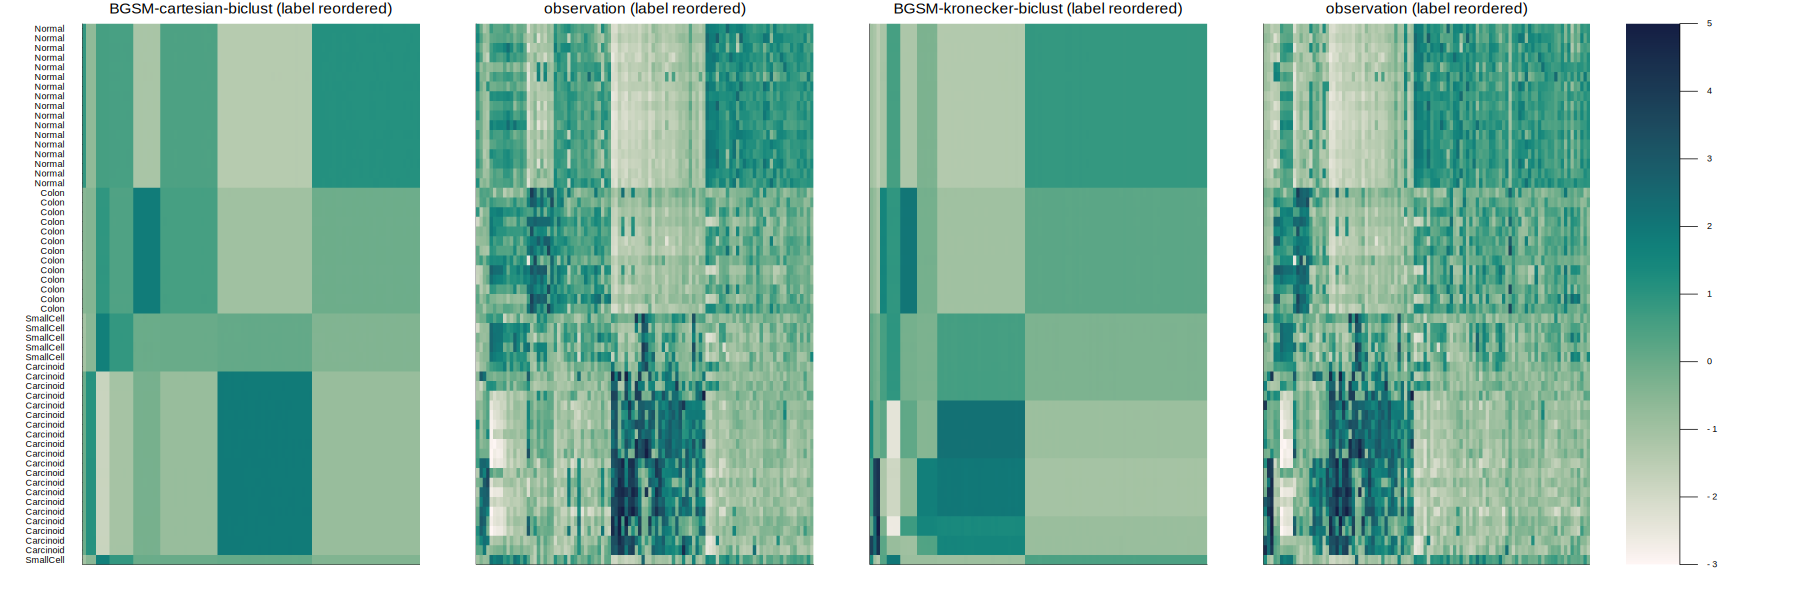

In [55]:
default(dpi = 300)
F1 = heatmap(out[:theta][ind1,ind4]', fillcolor = :tempo, clim = (-3,5),
        yticks = (1:56,cellnames[ind4]), legend = :none,  xticks = false,
        title = "BGSM-cartesian-biclust (label reordered)");
F2 = heatmap(X[ind1,ind4]' * 10, fillcolor = :tempo, clim = (-3,5), yticks = false, legend = :none,
         xticks = false, title = "observation (label reordered)");
F3 = heatmap(out2[:theta][ind3,ind4]', fillcolor = :tempo, clim = (-3,5), legend = :none, yticks = false,
         xticks = false, title = "BGSM-kronecker-biclust (label reordered)");
F4 = heatmap(X[ind3,ind4]' * 10, fillcolor = :tempo, clim = (-3,5), yticks = false, xticks = false,
        title = "observation (label reordered)");
F = Plots.plot(F1, F2, F3, F4, size = (2400,800), layout = grid(1,4,widths=[0.22,0.22,0.22,0.33]),
    left_margin = 10mm, bottom_margin = 10mm)